In [1]:
# Basic libraries
import torch
import torch.nn as n
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from PIL import Image
from typing import List
import torch.optim as optim
from tqdm import tqdm
from omegaconf import OmegaConf

In [2]:
os.chdir("../")
# Personalized modules
from preprocess.dataloader import AntibodiesTree
from preprocess.patches_utils import PatchesUtilities

from osgen.embeddings import StyleExtractor
from osgen.utils import Utilities
from osgen.vae import VanillaVAE,VanillaEncoder, VanillaDecoder
from osgen.base import BaseModel
from osgen.nn import *
from osgen.unet import *
from osgen.loss import *
from osgen.pipeline import *

In [3]:
# Load config
cfg = OmegaConf.load("/root/BiOSGen/configs/train_config.yml")
print(cfg.verbose)

True


In [4]:
# SRC antibodies
tree_src = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/HE",
    mask_dir = "/root/BiOSGen/data/tissue_masks/HE",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/HE"
)

# DST antibodies
tree_dst = AntibodiesTree(
    image_dir = "/root/BiOSGen/data/NKX3",
    mask_dir = "/root/BiOSGen/data/tissue_masks/NKX3",
    npz_dir = "/root/BiOSGen/data/bbox_info/HE_NKX3/NKX3"
)

# Print
print("Nb antibodies: ", tree_src.get_nb_antibodies())
print("Nb antibodies: ", tree_dst.get_nb_antibodies())

Nb antibodies:  248
Nb antibodies:  248


In [5]:
idx_src = 20 # torch.randint(0, len(tree_src.antibodies), (1,)).item()
patches_src = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_src.antibodies[idx_src])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[idx_src]))),
)

idx_dst = 60 # torch.randint(0, len(tree_dst.antibodies), (1,)).item()
patches_dst = PatchesUtilities.get_image_patches(
    image = np.array(Image.open(tree_dst.antibodies[idx_dst])),
    tissue_mask = PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_dst.antibodies[idx_dst]))),
)
print("idx_src: ", idx_src)
print("idx_dst: ", idx_dst)

idx_src:  20
idx_dst:  60


In [6]:
# Initialize your pipeline
pipeline = OSGenPipeline()

# # Load the checkpoint file (a state_dict)
# checkpoints = torch.load("/root/BiOSGen/checkpoints/main/pipeline_full_best_100_epoch_512.pth")


In [7]:
# checkpoint_keys = set(checkpoints['model_state_dict'].keys())
# pipeline_keys = set(pipeline.state_dict().keys())

# print("Keys only in checkpoint:", checkpoint_keys - pipeline_keys)
# print("Keys only in pipeline:", pipeline_keys - checkpoint_keys)
# print("Common keys:", checkpoint_keys & pipeline_keys)

# # Check for shape mismatches in common keys
# print("\nShape mismatches:")
# for key in checkpoint_keys & pipeline_keys:
#     if checkpoints['model_state_dict'][key].shape != pipeline.state_dict()[key].shape:
#         print(f"{key}: checkpoint shape = {checkpoints['model_state_dict'][key].shape}, pipeline shape = {pipeline.state_dict()[key].shape}")

In [8]:
# Hyperparameters
verbose = cfg.verbose
num_epochs = 100
batch_size = cfg.batch_size
lr = cfg.lr
optimizer = optim.AdamW([p for p in pipeline.parameters() if p.requires_grad], 
                        lr=cfg.optimizer.params.lr, weight_decay=cfg.optimizer.params.weight_decay, eps=cfg.optimizer.params.eps)

channels = cfg.channels
height = cfg.height
width = cfg.width
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

lambda_content = cfg.lambda_content
lambda_style = cfg.lambda_style
lambda_tv = cfg.lambda_tv

# Training loop
# Put on training mode
pipeline.train()
requires_grad = True

# Early stopping parameters
early_stopping_patience = cfg.early_stopping_patience
epochs_without_improvement = 0
best_loss = float("inf")

# Convergence check parameters
convergence_patience = 5  # Number of epochs to check for convergence
convergence_threshold = 0.001  # Minimum relative change in loss to continue training
loss_history = []  # Keep track of recent losses

# Save losses
losses = []
content_losses = []
style_losses = []
tv_losses = []

# Switch to main training with bfloat16
for epoch in tqdm(range(num_epochs)):
    # print(f"Epoch {epoch+1}/{num_epochs}")
    avg_loss = []
    content_loss = []
    style_loss = []
    tv_loss = []

    for i, (src, dst) in enumerate(zip(patches_src, patches_dst)):
        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src).to(device)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst).to(device)

        timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

        # forward pass
        decoded = pipeline(src_tensor, dst_tensor, timesteps)

        # Handle gradients issues
        requires_grad = decoded.requires_grad
        # print(requires_grad)
        if not requires_grad:
            break

        # Compute loss
        content_l, style_l, tv_l, total_loss = pipeline.compute_loss(src_tensor, dst_tensor, decoded, lambda_content, lambda_style, lambda_tv)

        # Break if total_loss is NaN
        if torch.isnan(total_loss):
            print(f"NaN loss at epoch {epoch+1}, batch {i+1}")
            break

        print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(patches_src)}, "
                f"Content Loss: {content_l.item():.4f}, Style Loss: {style_l.item():.4f}, "
                f"TV Loss: {tv_l.item():.4f}, Total Loss: {total_loss.item():.4f}")

        avg_loss.append(total_loss.item())
        content_loss.append(content_l.item())
        style_loss.append(style_l.item())
        tv_loss.append(tv_l.item())

        # Backpropagation
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
    
    current_loss = np.mean(avg_loss)
    losses.append(current_loss)
    content_losses.append(np.mean(content_loss))
    style_losses.append(np.mean(style_loss))

    # Early stopping (original implementation)
    if current_loss < best_loss:
        best_loss = current_loss
        epochs_without_improvement = 0
    else:
        epochs_without_improvement += 1

    if epochs_without_improvement >= early_stopping_patience:
        print(f"Early stopping at epoch {epoch+1}")
        break

    if verbose: 
        if epoch % 10 == 0:
            print(f"Epoch {epoch+1}/{num_epochs}, Batch {i+1}/{len(patches_src)}, "
                f"Content Loss: {content_l.item():.4f}, Style Loss: {style_l.item():.4f}, "
                f"Total Loss: {total_loss.item():.4f}")
            
            # Save the checkpoints
            torch.save(pipeline.state_dict(), f"/root/BiOSGen/checkpoints/pipeline_epoch_{epoch+1}.pth")
            print(f"Model saved at /root/BiOSGen/checkpoints/pipeline_epoch_{epoch+1}.pth")

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 1/100, Batch 1/95, Content Loss: 71.7606, Style Loss: 357.7734, TV Loss: 30.9399, Total Loss: 460.4739
Epoch 1/100, Batch 2/95, Content Loss: 48.1275, Style Loss: 170.2811, TV Loss: 51.3186, Total Loss: 269.7271
Epoch 1/100, Batch 3/95, Content Loss: 30.6916, Style Loss: 135.9047, TV Loss: 33.2967, Total Loss: 199.8930
Epoch 1/100, Batch 4/95, Content Loss: 52.9460, Style Loss: 298.4113, TV Loss: 84.2099, Total Loss: 435.5671
Epoch 1/100, Batch 5/95, Content Loss: 61.5542, Style Loss: 401.8752, TV Loss: 91.7140, Total Loss: 555.1434
Epoch 1/100, Batch 6/95, Content Loss: 76.2811, Style Loss: 265.3171, TV Loss: 35.3923, Total Loss: 376.9904
Epoch 1/100, Batch 7/95, Content Loss: 96.2361, Style Loss: 303.9962, TV Loss: 22.7222, Total Loss: 422.9545
Epoch 1/100, Batch 8/95, Content Loss: 67.6344, Style Loss: 413.2672, TV Loss: 69.4151, Total Loss: 550.3167
Epoch 1/100, Batch 9/95, Content Loss: 87.7718, Style Loss: 197.5772, TV Loss: 22.0557, Total Loss: 307.4046
Epoch 1/100, Batch 

  1%|          | 1/100 [00:18<31:07, 18.86s/it]

Model saved at /root/BiOSGen/checkpoints/pipeline_epoch_1.pth
Epoch 2/100, Batch 1/95, Content Loss: 37.9186, Style Loss: 85.0281, TV Loss: 31.6903, Total Loss: 154.6370
Epoch 2/100, Batch 2/95, Content Loss: 36.2858, Style Loss: 60.8138, TV Loss: 29.7664, Total Loss: 126.8661
Epoch 2/100, Batch 3/95, Content Loss: 28.1991, Style Loss: 89.6439, TV Loss: 23.6550, Total Loss: 141.4981
Epoch 2/100, Batch 4/95, Content Loss: 25.4199, Style Loss: 122.8803, TV Loss: 10.8351, Total Loss: 159.1353
Epoch 2/100, Batch 5/95, Content Loss: 30.7875, Style Loss: 75.3843, TV Loss: 25.3286, Total Loss: 131.5004
Epoch 2/100, Batch 6/95, Content Loss: 55.2962, Style Loss: 85.2360, TV Loss: 31.8043, Total Loss: 172.3364
Epoch 2/100, Batch 7/95, Content Loss: 65.6595, Style Loss: 48.8504, TV Loss: 41.9055, Total Loss: 156.4153
Epoch 2/100, Batch 8/95, Content Loss: 52.7065, Style Loss: 59.1039, TV Loss: 36.6449, Total Loss: 148.4553
Epoch 2/100, Batch 9/95, Content Loss: 55.9884, Style Loss: 37.2600, TV L

  2%|▏         | 2/100 [00:34<27:47, 17.02s/it]

Epoch 3/100, Batch 1/95, Content Loss: 28.6438, Style Loss: 70.4782, TV Loss: 22.3162, Total Loss: 121.4381
Epoch 3/100, Batch 2/95, Content Loss: 31.1598, Style Loss: 60.0830, TV Loss: 21.5794, Total Loss: 112.8221
Epoch 3/100, Batch 3/95, Content Loss: 23.1153, Style Loss: 90.0410, TV Loss: 16.1207, Total Loss: 129.2770
Epoch 3/100, Batch 4/95, Content Loss: 24.4942, Style Loss: 87.2259, TV Loss: 17.0051, Total Loss: 128.7252
Epoch 3/100, Batch 5/95, Content Loss: 28.5475, Style Loss: 71.5492, TV Loss: 25.0994, Total Loss: 125.1961
Epoch 3/100, Batch 6/95, Content Loss: 56.0100, Style Loss: 66.7118, TV Loss: 41.8578, Total Loss: 164.5795
Epoch 3/100, Batch 7/95, Content Loss: 65.0014, Style Loss: 55.8863, TV Loss: 45.0652, Total Loss: 165.9529
Epoch 3/100, Batch 8/95, Content Loss: 56.0306, Style Loss: 88.1448, TV Loss: 30.0358, Total Loss: 174.2112
Epoch 3/100, Batch 9/95, Content Loss: 56.3631, Style Loss: 35.0320, TV Loss: 42.7397, Total Loss: 134.1347
Epoch 3/100, Batch 10/95, Co

  3%|▎         | 3/100 [00:50<26:22, 16.31s/it]

Epoch 4/100, Batch 1/95, Content Loss: 26.1150, Style Loss: 42.7607, TV Loss: 25.7470, Total Loss: 94.6228
Epoch 4/100, Batch 2/95, Content Loss: 27.1726, Style Loss: 44.4808, TV Loss: 22.5584, Total Loss: 94.2118
Epoch 4/100, Batch 3/95, Content Loss: 18.0585, Style Loss: 62.4833, TV Loss: 16.9295, Total Loss: 97.4714
Epoch 4/100, Batch 4/95, Content Loss: 12.7677, Style Loss: 57.2327, TV Loss: 25.1691, Total Loss: 95.1694
Epoch 4/100, Batch 5/95, Content Loss: 22.4361, Style Loss: 142.4792, TV Loss: 22.2462, Total Loss: 187.1615
Epoch 4/100, Batch 6/95, Content Loss: 60.8405, Style Loss: 128.3007, TV Loss: 30.1732, Total Loss: 219.3144
Epoch 4/100, Batch 7/95, Content Loss: 75.5196, Style Loss: 54.6893, TV Loss: 39.7876, Total Loss: 169.9965
Epoch 4/100, Batch 8/95, Content Loss: 74.0693, Style Loss: 53.8742, TV Loss: 43.6405, Total Loss: 171.5841
Epoch 4/100, Batch 9/95, Content Loss: 71.5630, Style Loss: 93.9564, TV Loss: 40.1634, Total Loss: 205.6828
Epoch 4/100, Batch 10/95, Cont

  4%|▍         | 4/100 [01:05<25:33, 15.98s/it]

Epoch 4/100, Batch 94/95, Content Loss: 42.0343, Style Loss: 49.9052, TV Loss: 27.5227, Total Loss: 119.4622
Epoch 5/100, Batch 1/95, Content Loss: 29.2057, Style Loss: 42.2248, TV Loss: 27.0257, Total Loss: 98.4562
Epoch 5/100, Batch 2/95, Content Loss: 30.2690, Style Loss: 33.5941, TV Loss: 25.4137, Total Loss: 89.2768
Epoch 5/100, Batch 3/95, Content Loss: 22.1445, Style Loss: 50.7417, TV Loss: 20.1747, Total Loss: 93.0609
Epoch 5/100, Batch 4/95, Content Loss: 16.5280, Style Loss: 42.9256, TV Loss: 21.4590, Total Loss: 80.9127
Epoch 5/100, Batch 5/95, Content Loss: 24.8174, Style Loss: 134.0266, TV Loss: 22.3184, Total Loss: 181.1624
Epoch 5/100, Batch 6/95, Content Loss: 60.5398, Style Loss: 89.8261, TV Loss: 29.8262, Total Loss: 180.1921
Epoch 5/100, Batch 7/95, Content Loss: 70.6547, Style Loss: 58.3581, TV Loss: 31.9358, Total Loss: 160.9486
Epoch 5/100, Batch 8/95, Content Loss: 62.3486, Style Loss: 68.2919, TV Loss: 32.0682, Total Loss: 162.7087
Epoch 5/100, Batch 9/95, Conte

  5%|▌         | 5/100 [01:20<24:57, 15.76s/it]

Epoch 5/100, Batch 94/95, Content Loss: 43.6649, Style Loss: 64.4969, TV Loss: 32.1925, Total Loss: 140.3544
Epoch 6/100, Batch 1/95, Content Loss: 31.0787, Style Loss: 34.8685, TV Loss: 29.7548, Total Loss: 95.7021
Epoch 6/100, Batch 2/95, Content Loss: 31.0744, Style Loss: 27.8210, TV Loss: 24.9141, Total Loss: 83.8095
Epoch 6/100, Batch 3/95, Content Loss: 22.5671, Style Loss: 38.5986, TV Loss: 21.3582, Total Loss: 82.5239
Epoch 6/100, Batch 4/95, Content Loss: 16.4753, Style Loss: 48.7618, TV Loss: 18.4109, Total Loss: 83.6479
Epoch 6/100, Batch 5/95, Content Loss: 34.1232, Style Loss: 63.5794, TV Loss: 26.8989, Total Loss: 124.6016
Epoch 6/100, Batch 6/95, Content Loss: 58.0421, Style Loss: 48.6964, TV Loss: 29.2335, Total Loss: 135.9720
Epoch 6/100, Batch 7/95, Content Loss: 71.6570, Style Loss: 41.9629, TV Loss: 33.9517, Total Loss: 147.5716
Epoch 6/100, Batch 8/95, Content Loss: 59.3924, Style Loss: 58.8191, TV Loss: 26.2145, Total Loss: 144.4261
Epoch 6/100, Batch 9/95, Conten

  6%|▌         | 6/100 [01:36<24:51, 15.86s/it]

Epoch 7/100, Batch 1/95, Content Loss: 26.9433, Style Loss: 42.6301, TV Loss: 24.1841, Total Loss: 93.7575
Epoch 7/100, Batch 2/95, Content Loss: 25.9979, Style Loss: 48.2630, TV Loss: 19.4627, Total Loss: 93.7236
Epoch 7/100, Batch 3/95, Content Loss: 19.2672, Style Loss: 42.5834, TV Loss: 19.1040, Total Loss: 80.9545
Epoch 7/100, Batch 4/95, Content Loss: 15.5836, Style Loss: 55.6968, TV Loss: 17.3942, Total Loss: 88.6746
Epoch 7/100, Batch 5/95, Content Loss: 25.9244, Style Loss: 85.3996, TV Loss: 20.0535, Total Loss: 131.3775
Epoch 7/100, Batch 6/95, Content Loss: 69.5644, Style Loss: 46.5095, TV Loss: 33.3884, Total Loss: 149.4624
Epoch 7/100, Batch 7/95, Content Loss: 68.1303, Style Loss: 38.6818, TV Loss: 33.1741, Total Loss: 139.9862
Epoch 7/100, Batch 8/95, Content Loss: 55.7660, Style Loss: 45.1434, TV Loss: 32.2516, Total Loss: 133.1611
Epoch 7/100, Batch 9/95, Content Loss: 54.9036, Style Loss: 33.3351, TV Loss: 28.5492, Total Loss: 116.7879
Epoch 7/100, Batch 10/95, Conten

  7%|▋         | 7/100 [01:52<24:21, 15.71s/it]

Epoch 8/100, Batch 1/95, Content Loss: 22.8611, Style Loss: 24.4850, TV Loss: 23.2839, Total Loss: 70.6300
Epoch 8/100, Batch 2/95, Content Loss: 26.6687, Style Loss: 23.1113, TV Loss: 24.4584, Total Loss: 74.2384
Epoch 8/100, Batch 3/95, Content Loss: 19.4462, Style Loss: 30.9426, TV Loss: 19.9303, Total Loss: 70.3192
Epoch 8/100, Batch 4/95, Content Loss: 15.0078, Style Loss: 24.2716, TV Loss: 22.0310, Total Loss: 61.3103
Epoch 8/100, Batch 5/95, Content Loss: 35.8396, Style Loss: 60.6963, TV Loss: 29.8076, Total Loss: 126.3435
Epoch 8/100, Batch 6/95, Content Loss: 53.1476, Style Loss: 32.6566, TV Loss: 33.7403, Total Loss: 119.5444
Epoch 8/100, Batch 7/95, Content Loss: 60.8962, Style Loss: 21.2140, TV Loss: 38.8028, Total Loss: 120.9130
Epoch 8/100, Batch 8/95, Content Loss: 55.4891, Style Loss: 36.4576, TV Loss: 33.5720, Total Loss: 125.5188
Epoch 8/100, Batch 9/95, Content Loss: 52.2747, Style Loss: 28.8717, TV Loss: 28.9513, Total Loss: 110.0977
Epoch 8/100, Batch 10/95, Conten

  8%|▊         | 8/100 [02:07<24:01, 15.66s/it]

Epoch 9/100, Batch 1/95, Content Loss: 17.8999, Style Loss: 26.5068, TV Loss: 20.4836, Total Loss: 64.8903
Epoch 9/100, Batch 2/95, Content Loss: 24.8859, Style Loss: 23.6496, TV Loss: 25.5221, Total Loss: 74.0577
Epoch 9/100, Batch 3/95, Content Loss: 17.2078, Style Loss: 33.1923, TV Loss: 20.1775, Total Loss: 70.5776
Epoch 9/100, Batch 4/95, Content Loss: 11.2687, Style Loss: 28.5975, TV Loss: 18.7251, Total Loss: 58.5912
Epoch 9/100, Batch 5/95, Content Loss: 38.9123, Style Loss: 40.5894, TV Loss: 30.3600, Total Loss: 109.8617
Epoch 9/100, Batch 6/95, Content Loss: 63.6980, Style Loss: 34.2159, TV Loss: 32.9798, Total Loss: 130.8937
Epoch 9/100, Batch 7/95, Content Loss: 66.5523, Style Loss: 31.8251, TV Loss: 40.7800, Total Loss: 139.1574
Epoch 9/100, Batch 8/95, Content Loss: 62.5668, Style Loss: 36.2152, TV Loss: 38.2063, Total Loss: 136.9883
Epoch 9/100, Batch 9/95, Content Loss: 50.6926, Style Loss: 27.8865, TV Loss: 39.5150, Total Loss: 118.0941
Epoch 9/100, Batch 10/95, Conten

  9%|▉         | 9/100 [02:23<23:37, 15.58s/it]

Epoch 10/100, Batch 1/95, Content Loss: 25.5055, Style Loss: 41.5447, TV Loss: 21.5024, Total Loss: 88.5526
Epoch 10/100, Batch 2/95, Content Loss: 31.2215, Style Loss: 21.1177, TV Loss: 27.7567, Total Loss: 80.0959
Epoch 10/100, Batch 3/95, Content Loss: 21.5212, Style Loss: 30.2978, TV Loss: 22.2333, Total Loss: 74.0523
Epoch 10/100, Batch 4/95, Content Loss: 17.2391, Style Loss: 20.6574, TV Loss: 24.4431, Total Loss: 62.3397
Epoch 10/100, Batch 5/95, Content Loss: 27.2574, Style Loss: 78.4662, TV Loss: 24.0134, Total Loss: 129.7370
Epoch 10/100, Batch 6/95, Content Loss: 47.2966, Style Loss: 65.8590, TV Loss: 28.5873, Total Loss: 141.7429
Epoch 10/100, Batch 7/95, Content Loss: 60.8799, Style Loss: 54.1653, TV Loss: 34.3097, Total Loss: 149.3548
Epoch 10/100, Batch 8/95, Content Loss: 51.3604, Style Loss: 60.0811, TV Loss: 29.4675, Total Loss: 140.9089
Epoch 10/100, Batch 9/95, Content Loss: 52.8803, Style Loss: 29.8246, TV Loss: 28.3376, Total Loss: 111.0425
Epoch 10/100, Batch 10/

 10%|█         | 10/100 [02:38<23:17, 15.53s/it]

Epoch 11/100, Batch 1/95, Content Loss: 25.2706, Style Loss: 43.9300, TV Loss: 20.0399, Total Loss: 89.2405
Epoch 11/100, Batch 2/95, Content Loss: 25.6451, Style Loss: 25.8046, TV Loss: 21.7256, Total Loss: 73.1753
Epoch 11/100, Batch 3/95, Content Loss: 18.1342, Style Loss: 52.2266, TV Loss: 16.4306, Total Loss: 86.7914
Epoch 11/100, Batch 4/95, Content Loss: 14.0177, Style Loss: 42.3129, TV Loss: 15.9675, Total Loss: 72.2981
Epoch 11/100, Batch 5/95, Content Loss: 35.8889, Style Loss: 70.8727, TV Loss: 21.3872, Total Loss: 128.1488
Epoch 11/100, Batch 6/95, Content Loss: 52.9962, Style Loss: 36.7451, TV Loss: 29.6926, Total Loss: 119.4339
Epoch 11/100, Batch 7/95, Content Loss: 58.5754, Style Loss: 37.2876, TV Loss: 36.6968, Total Loss: 132.5599
Epoch 11/100, Batch 8/95, Content Loss: 50.8127, Style Loss: 56.0034, TV Loss: 29.9876, Total Loss: 136.8037
Epoch 11/100, Batch 9/95, Content Loss: 51.3545, Style Loss: 41.9109, TV Loss: 31.1809, Total Loss: 124.4464
Epoch 11/100, Batch 10/

 11%|█         | 11/100 [02:55<23:26, 15.80s/it]

Model saved at /root/BiOSGen/checkpoints/pipeline_epoch_11.pth
Epoch 12/100, Batch 1/95, Content Loss: 18.8503, Style Loss: 28.3443, TV Loss: 18.0691, Total Loss: 65.2636
Epoch 12/100, Batch 2/95, Content Loss: 27.7883, Style Loss: 23.8085, TV Loss: 22.8722, Total Loss: 74.4691
Epoch 12/100, Batch 3/95, Content Loss: 19.4164, Style Loss: 34.7266, TV Loss: 18.7722, Total Loss: 72.9152
Epoch 12/100, Batch 4/95, Content Loss: 8.2207, Style Loss: 46.1714, TV Loss: 15.5347, Total Loss: 69.9268
Epoch 12/100, Batch 5/95, Content Loss: 33.9390, Style Loss: 49.6212, TV Loss: 27.3714, Total Loss: 110.9317
Epoch 12/100, Batch 6/95, Content Loss: 55.6640, Style Loss: 34.0087, TV Loss: 31.0630, Total Loss: 120.7357
Epoch 12/100, Batch 7/95, Content Loss: 61.4786, Style Loss: 20.8390, TV Loss: 36.7527, Total Loss: 119.0703
Epoch 12/100, Batch 8/95, Content Loss: 52.8169, Style Loss: 41.2829, TV Loss: 31.5971, Total Loss: 125.6970
Epoch 12/100, Batch 9/95, Content Loss: 52.1144, Style Loss: 21.1848, 

 12%|█▏        | 12/100 [03:10<23:04, 15.74s/it]

Epoch 13/100, Batch 1/95, Content Loss: 19.3147, Style Loss: 24.7465, TV Loss: 18.6327, Total Loss: 62.6939
Epoch 13/100, Batch 2/95, Content Loss: 26.5594, Style Loss: 21.8283, TV Loss: 21.8202, Total Loss: 70.2079
Epoch 13/100, Batch 3/95, Content Loss: 18.1557, Style Loss: 34.5208, TV Loss: 17.3609, Total Loss: 70.0373
Epoch 13/100, Batch 4/95, Content Loss: 15.7736, Style Loss: 20.5876, TV Loss: 20.3493, Total Loss: 56.7105
Epoch 13/100, Batch 5/95, Content Loss: 48.7920, Style Loss: 60.5744, TV Loss: 29.9895, Total Loss: 139.3559
Epoch 13/100, Batch 6/95, Content Loss: 55.5785, Style Loss: 19.9375, TV Loss: 37.4210, Total Loss: 112.9370
Epoch 13/100, Batch 7/95, Content Loss: 60.0754, Style Loss: 21.6976, TV Loss: 42.9963, Total Loss: 124.7693
Epoch 13/100, Batch 8/95, Content Loss: 52.8703, Style Loss: 38.1504, TV Loss: 32.8150, Total Loss: 123.8357
Epoch 13/100, Batch 9/95, Content Loss: 50.3333, Style Loss: 26.6374, TV Loss: 29.5130, Total Loss: 106.4837
Epoch 13/100, Batch 10/

 13%|█▎        | 13/100 [03:26<22:42, 15.66s/it]

Epoch 13/100, Batch 94/95, Content Loss: 39.4728, Style Loss: 26.6118, TV Loss: 26.4970, Total Loss: 92.5817
Epoch 14/100, Batch 1/95, Content Loss: 19.9094, Style Loss: 23.6456, TV Loss: 19.6347, Total Loss: 63.1897
Epoch 14/100, Batch 2/95, Content Loss: 27.8428, Style Loss: 20.2039, TV Loss: 24.3445, Total Loss: 72.3913
Epoch 14/100, Batch 3/95, Content Loss: 17.0960, Style Loss: 38.1181, TV Loss: 16.3832, Total Loss: 71.5973
Epoch 14/100, Batch 4/95, Content Loss: 14.1217, Style Loss: 22.0079, TV Loss: 19.0372, Total Loss: 55.1669
Epoch 14/100, Batch 5/95, Content Loss: 42.0376, Style Loss: 61.3021, TV Loss: 24.8054, Total Loss: 128.1451
Epoch 14/100, Batch 6/95, Content Loss: 59.7786, Style Loss: 20.8687, TV Loss: 37.8219, Total Loss: 118.4691
Epoch 14/100, Batch 7/95, Content Loss: 63.1433, Style Loss: 20.8682, TV Loss: 40.6845, Total Loss: 124.6960
Epoch 14/100, Batch 8/95, Content Loss: 53.3920, Style Loss: 34.1590, TV Loss: 34.4255, Total Loss: 121.9764
Epoch 14/100, Batch 9/9

 14%|█▍        | 14/100 [03:41<22:21, 15.60s/it]

Epoch 14/100, Batch 94/95, Content Loss: 36.2691, Style Loss: 26.5994, TV Loss: 24.1143, Total Loss: 86.9828
Epoch 15/100, Batch 1/95, Content Loss: 19.5872, Style Loss: 24.5201, TV Loss: 18.6821, Total Loss: 62.7895
Epoch 15/100, Batch 2/95, Content Loss: 25.6976, Style Loss: 20.4031, TV Loss: 22.8852, Total Loss: 68.9858
Epoch 15/100, Batch 3/95, Content Loss: 18.4150, Style Loss: 27.8620, TV Loss: 18.9939, Total Loss: 65.2709
Epoch 15/100, Batch 4/95, Content Loss: 14.0221, Style Loss: 21.5804, TV Loss: 19.1600, Total Loss: 54.7625
Epoch 15/100, Batch 5/95, Content Loss: 33.5227, Style Loss: 50.4448, TV Loss: 23.5371, Total Loss: 107.5045
Epoch 15/100, Batch 6/95, Content Loss: 52.9610, Style Loss: 25.2477, TV Loss: 32.3149, Total Loss: 110.5236
Epoch 15/100, Batch 7/95, Content Loss: 61.2408, Style Loss: 18.0603, TV Loss: 37.9395, Total Loss: 117.2406
Epoch 15/100, Batch 8/95, Content Loss: 52.9902, Style Loss: 39.6146, TV Loss: 31.5093, Total Loss: 124.1141
Epoch 15/100, Batch 9/9

 15%|█▌        | 15/100 [03:57<21:59, 15.52s/it]

Epoch 15/100, Batch 94/95, Content Loss: 46.4612, Style Loss: 94.0810, TV Loss: 33.3084, Total Loss: 173.8506
Epoch 16/100, Batch 1/95, Content Loss: 31.4515, Style Loss: 84.6814, TV Loss: 26.9310, Total Loss: 143.0639
Epoch 16/100, Batch 2/95, Content Loss: 32.7389, Style Loss: 73.4151, TV Loss: 26.1004, Total Loss: 132.2544
Epoch 16/100, Batch 3/95, Content Loss: 25.4655, Style Loss: 96.6011, TV Loss: 23.3641, Total Loss: 145.4306
Epoch 16/100, Batch 4/95, Content Loss: 18.9077, Style Loss: 57.2171, TV Loss: 22.0784, Total Loss: 98.2031
Epoch 16/100, Batch 5/95, Content Loss: 23.7693, Style Loss: 96.3486, TV Loss: 20.2519, Total Loss: 140.3698
Epoch 16/100, Batch 6/95, Content Loss: 52.4273, Style Loss: 99.9118, TV Loss: 28.9249, Total Loss: 181.2640
Epoch 16/100, Batch 7/95, Content Loss: 68.7769, Style Loss: 99.4061, TV Loss: 36.6646, Total Loss: 204.8476
Epoch 16/100, Batch 8/95, Content Loss: 50.3608, Style Loss: 123.9557, TV Loss: 26.6083, Total Loss: 200.9248
Epoch 16/100, Batc

 16%|█▌        | 16/100 [04:12<21:43, 15.52s/it]

Epoch 16/100, Batch 94/95, Content Loss: 38.9689, Style Loss: 59.6182, TV Loss: 30.6748, Total Loss: 129.2619
Epoch 17/100, Batch 1/95, Content Loss: 24.8032, Style Loss: 64.1329, TV Loss: 19.1823, Total Loss: 108.1184
Epoch 17/100, Batch 2/95, Content Loss: 29.4479, Style Loss: 30.0975, TV Loss: 25.8120, Total Loss: 85.3573
Epoch 17/100, Batch 3/95, Content Loss: 19.0244, Style Loss: 41.5565, TV Loss: 19.3555, Total Loss: 79.9364
Epoch 17/100, Batch 4/95, Content Loss: 10.6144, Style Loss: 38.0712, TV Loss: 17.0176, Total Loss: 65.7031
Epoch 17/100, Batch 5/95, Content Loss: 19.5530, Style Loss: 131.8364, TV Loss: 19.8279, Total Loss: 171.2173
Epoch 17/100, Batch 6/95, Content Loss: 59.2536, Style Loss: 36.0229, TV Loss: 32.8467, Total Loss: 128.1231
Epoch 17/100, Batch 7/95, Content Loss: 71.3834, Style Loss: 45.9005, TV Loss: 34.5142, Total Loss: 151.7982
Epoch 17/100, Batch 8/95, Content Loss: 58.8708, Style Loss: 41.8610, TV Loss: 32.8215, Total Loss: 133.5533
Epoch 17/100, Batch 

 17%|█▋        | 17/100 [04:27<21:24, 15.48s/it]

Epoch 17/100, Batch 94/95, Content Loss: 34.1457, Style Loss: 30.3548, TV Loss: 25.4490, Total Loss: 89.9496
Epoch 18/100, Batch 1/95, Content Loss: 23.6980, Style Loss: 26.1747, TV Loss: 23.1226, Total Loss: 72.9953
Epoch 18/100, Batch 2/95, Content Loss: 26.2414, Style Loss: 22.8897, TV Loss: 24.7053, Total Loss: 73.8364
Epoch 18/100, Batch 3/95, Content Loss: 18.1248, Style Loss: 30.6020, TV Loss: 19.7185, Total Loss: 68.4453
Epoch 18/100, Batch 4/95, Content Loss: 12.8149, Style Loss: 28.7344, TV Loss: 20.5865, Total Loss: 62.1358
Epoch 18/100, Batch 5/95, Content Loss: 23.0383, Style Loss: 91.5259, TV Loss: 20.6858, Total Loss: 135.2500
Epoch 18/100, Batch 6/95, Content Loss: 51.5617, Style Loss: 36.9181, TV Loss: 30.9648, Total Loss: 119.4445
Epoch 18/100, Batch 7/95, Content Loss: 63.4118, Style Loss: 24.3736, TV Loss: 36.5645, Total Loss: 124.3500
Epoch 18/100, Batch 8/95, Content Loss: 50.7874, Style Loss: 46.5416, TV Loss: 31.5935, Total Loss: 128.9225
Epoch 18/100, Batch 9/9

 18%|█▊        | 18/100 [04:43<21:07, 15.46s/it]

Epoch 18/100, Batch 94/95, Content Loss: 34.7834, Style Loss: 28.2907, TV Loss: 23.8053, Total Loss: 86.8795
Epoch 19/100, Batch 1/95, Content Loss: 25.0799, Style Loss: 33.9945, TV Loss: 22.5376, Total Loss: 81.6121
Epoch 19/100, Batch 2/95, Content Loss: 28.4558, Style Loss: 20.3829, TV Loss: 26.2361, Total Loss: 75.0749
Epoch 19/100, Batch 3/95, Content Loss: 18.0858, Style Loss: 29.8821, TV Loss: 19.7802, Total Loss: 67.7481
Epoch 19/100, Batch 4/95, Content Loss: 15.6845, Style Loss: 22.8873, TV Loss: 22.5328, Total Loss: 61.1046
Epoch 19/100, Batch 5/95, Content Loss: 28.1987, Style Loss: 68.2780, TV Loss: 25.1365, Total Loss: 121.6132
Epoch 19/100, Batch 6/95, Content Loss: 48.5441, Style Loss: 44.2107, TV Loss: 32.0067, Total Loss: 124.7614
Epoch 19/100, Batch 7/95, Content Loss: 59.5623, Style Loss: 26.9865, TV Loss: 37.5105, Total Loss: 124.0592
Epoch 19/100, Batch 8/95, Content Loss: 47.3158, Style Loss: 58.5799, TV Loss: 29.3552, Total Loss: 135.2509
Epoch 19/100, Batch 9/9

 19%|█▉        | 19/100 [04:58<20:48, 15.41s/it]

Epoch 19/100, Batch 94/95, Content Loss: 46.6889, Style Loss: 57.8991, TV Loss: 37.0054, Total Loss: 141.5933
Epoch 20/100, Batch 1/95, Content Loss: 27.8476, Style Loss: 43.3469, TV Loss: 22.8585, Total Loss: 94.0530
Epoch 20/100, Batch 2/95, Content Loss: 28.8208, Style Loss: 36.4084, TV Loss: 22.3058, Total Loss: 87.5350
Epoch 20/100, Batch 3/95, Content Loss: 20.6318, Style Loss: 49.1934, TV Loss: 18.7776, Total Loss: 88.6028
Epoch 20/100, Batch 4/95, Content Loss: 22.7161, Style Loss: 102.4237, TV Loss: 12.2863, Total Loss: 137.4261
Epoch 20/100, Batch 5/95, Content Loss: 36.0155, Style Loss: 178.4040, TV Loss: 20.5078, Total Loss: 234.9272
Epoch 20/100, Batch 6/95, Content Loss: 89.1871, Style Loss: 380.6910, TV Loss: 49.6445, Total Loss: 519.5226
Epoch 20/100, Batch 7/95, Content Loss: 100.1093, Style Loss: 333.8215, TV Loss: 50.3408, Total Loss: 484.2716
Epoch 20/100, Batch 8/95, Content Loss: 84.3711, Style Loss: 263.4984, TV Loss: 26.7274, Total Loss: 374.5969
Epoch 20/100, B

 20%|██        | 20/100 [05:14<20:36, 15.45s/it]

Epoch 20/100, Batch 94/95, Content Loss: 49.5155, Style Loss: 71.9720, TV Loss: 33.3769, Total Loss: 154.8643
Epoch 21/100, Batch 1/95, Content Loss: 28.4585, Style Loss: 34.2123, TV Loss: 24.9430, Total Loss: 87.6138
Epoch 21/100, Batch 2/95, Content Loss: 39.9412, Style Loss: 53.6208, TV Loss: 36.7302, Total Loss: 130.2923
Epoch 21/100, Batch 3/95, Content Loss: 26.7285, Style Loss: 68.6972, TV Loss: 21.4345, Total Loss: 116.8602
Epoch 21/100, Batch 4/95, Content Loss: 28.3530, Style Loss: 82.0834, TV Loss: 32.1242, Total Loss: 142.5606
Epoch 21/100, Batch 5/95, Content Loss: 44.4305, Style Loss: 44.8052, TV Loss: 37.8333, Total Loss: 127.0690
Epoch 21/100, Batch 6/95, Content Loss: 72.7364, Style Loss: 63.1080, TV Loss: 28.5164, Total Loss: 164.3609
Epoch 21/100, Batch 7/95, Content Loss: 77.2128, Style Loss: 55.8454, TV Loss: 29.4380, Total Loss: 162.4963
Epoch 21/100, Batch 8/95, Content Loss: 68.9846, Style Loss: 75.5348, TV Loss: 24.8733, Total Loss: 169.3927
Epoch 21/100, Batch

 21%|██        | 21/100 [05:30<20:46, 15.78s/it]

Model saved at /root/BiOSGen/checkpoints/pipeline_epoch_21.pth
Epoch 22/100, Batch 1/95, Content Loss: 33.2925, Style Loss: 35.6051, TV Loss: 26.8449, Total Loss: 95.7425
Epoch 22/100, Batch 2/95, Content Loss: 28.1625, Style Loss: 41.4077, TV Loss: 18.5773, Total Loss: 88.1475
Epoch 22/100, Batch 3/95, Content Loss: 25.1063, Style Loss: 52.0417, TV Loss: 21.2749, Total Loss: 98.4229
Epoch 22/100, Batch 4/95, Content Loss: 16.1792, Style Loss: 37.0904, TV Loss: 19.7325, Total Loss: 73.0021
Epoch 22/100, Batch 5/95, Content Loss: 47.8792, Style Loss: 28.6034, TV Loss: 39.4997, Total Loss: 115.9823
Epoch 22/100, Batch 6/95, Content Loss: 75.1870, Style Loss: 26.5737, TV Loss: 40.9122, Total Loss: 142.6729
Epoch 22/100, Batch 7/95, Content Loss: 76.0144, Style Loss: 40.5468, TV Loss: 31.9992, Total Loss: 148.5604
Epoch 22/100, Batch 8/95, Content Loss: 67.2857, Style Loss: 58.9573, TV Loss: 27.1013, Total Loss: 153.3443
Epoch 22/100, Batch 9/95, Content Loss: 63.4150, Style Loss: 34.9052,

 22%|██▏       | 22/100 [05:46<20:21, 15.66s/it]

Epoch 22/100, Batch 94/95, Content Loss: 72.6894, Style Loss: 190.1186, TV Loss: 31.0359, Total Loss: 293.8439
Epoch 23/100, Batch 1/95, Content Loss: 41.5999, Style Loss: 147.5597, TV Loss: 30.2364, Total Loss: 219.3960
Epoch 23/100, Batch 2/95, Content Loss: 40.1511, Style Loss: 89.7703, TV Loss: 27.5285, Total Loss: 157.4499
Epoch 23/100, Batch 3/95, Content Loss: 32.9054, Style Loss: 114.3176, TV Loss: 27.3767, Total Loss: 174.5997
Epoch 23/100, Batch 4/95, Content Loss: 27.9420, Style Loss: 64.7733, TV Loss: 34.6277, Total Loss: 127.3430
Epoch 23/100, Batch 5/95, Content Loss: 32.3144, Style Loss: 87.2203, TV Loss: 25.9278, Total Loss: 145.4625
Epoch 23/100, Batch 6/95, Content Loss: 75.7803, Style Loss: 126.4839, TV Loss: 43.7122, Total Loss: 245.9765
Epoch 23/100, Batch 7/95, Content Loss: 91.3332, Style Loss: 104.6113, TV Loss: 28.9236, Total Loss: 224.8680
Epoch 23/100, Batch 8/95, Content Loss: 72.2841, Style Loss: 95.9998, TV Loss: 29.0068, Total Loss: 197.2907
Epoch 23/100,

 23%|██▎       | 23/100 [06:01<20:04, 15.65s/it]

Epoch 23/100, Batch 94/95, Content Loss: 64.1263, Style Loss: 84.6936, TV Loss: 27.4563, Total Loss: 176.2761
Epoch 24/100, Batch 1/95, Content Loss: 41.6759, Style Loss: 104.8673, TV Loss: 27.1795, Total Loss: 173.7227
Epoch 24/100, Batch 2/95, Content Loss: 48.5692, Style Loss: 59.8992, TV Loss: 26.8063, Total Loss: 135.2747
Epoch 24/100, Batch 3/95, Content Loss: 43.4369, Style Loss: 77.4807, TV Loss: 26.6531, Total Loss: 147.5707
Epoch 24/100, Batch 4/95, Content Loss: 35.5352, Style Loss: 64.9813, TV Loss: 28.9107, Total Loss: 129.4272
Epoch 24/100, Batch 5/95, Content Loss: 31.7733, Style Loss: 104.7304, TV Loss: 20.9930, Total Loss: 157.4967
Epoch 24/100, Batch 6/95, Content Loss: 78.9366, Style Loss: 156.4212, TV Loss: 25.1114, Total Loss: 260.4692
Epoch 24/100, Batch 7/95, Content Loss: 96.9027, Style Loss: 144.6201, TV Loss: 27.2617, Total Loss: 268.7846
Epoch 24/100, Batch 8/95, Content Loss: 82.7560, Style Loss: 166.0634, TV Loss: 28.3737, Total Loss: 277.1931
Epoch 24/100,

 23%|██▎       | 23/100 [06:17<21:03, 16.41s/it]

Epoch 24/100, Batch 94/95, Content Loss: 58.0017, Style Loss: 74.0835, TV Loss: 25.6491, Total Loss: 157.7343
Early stopping at epoch 24


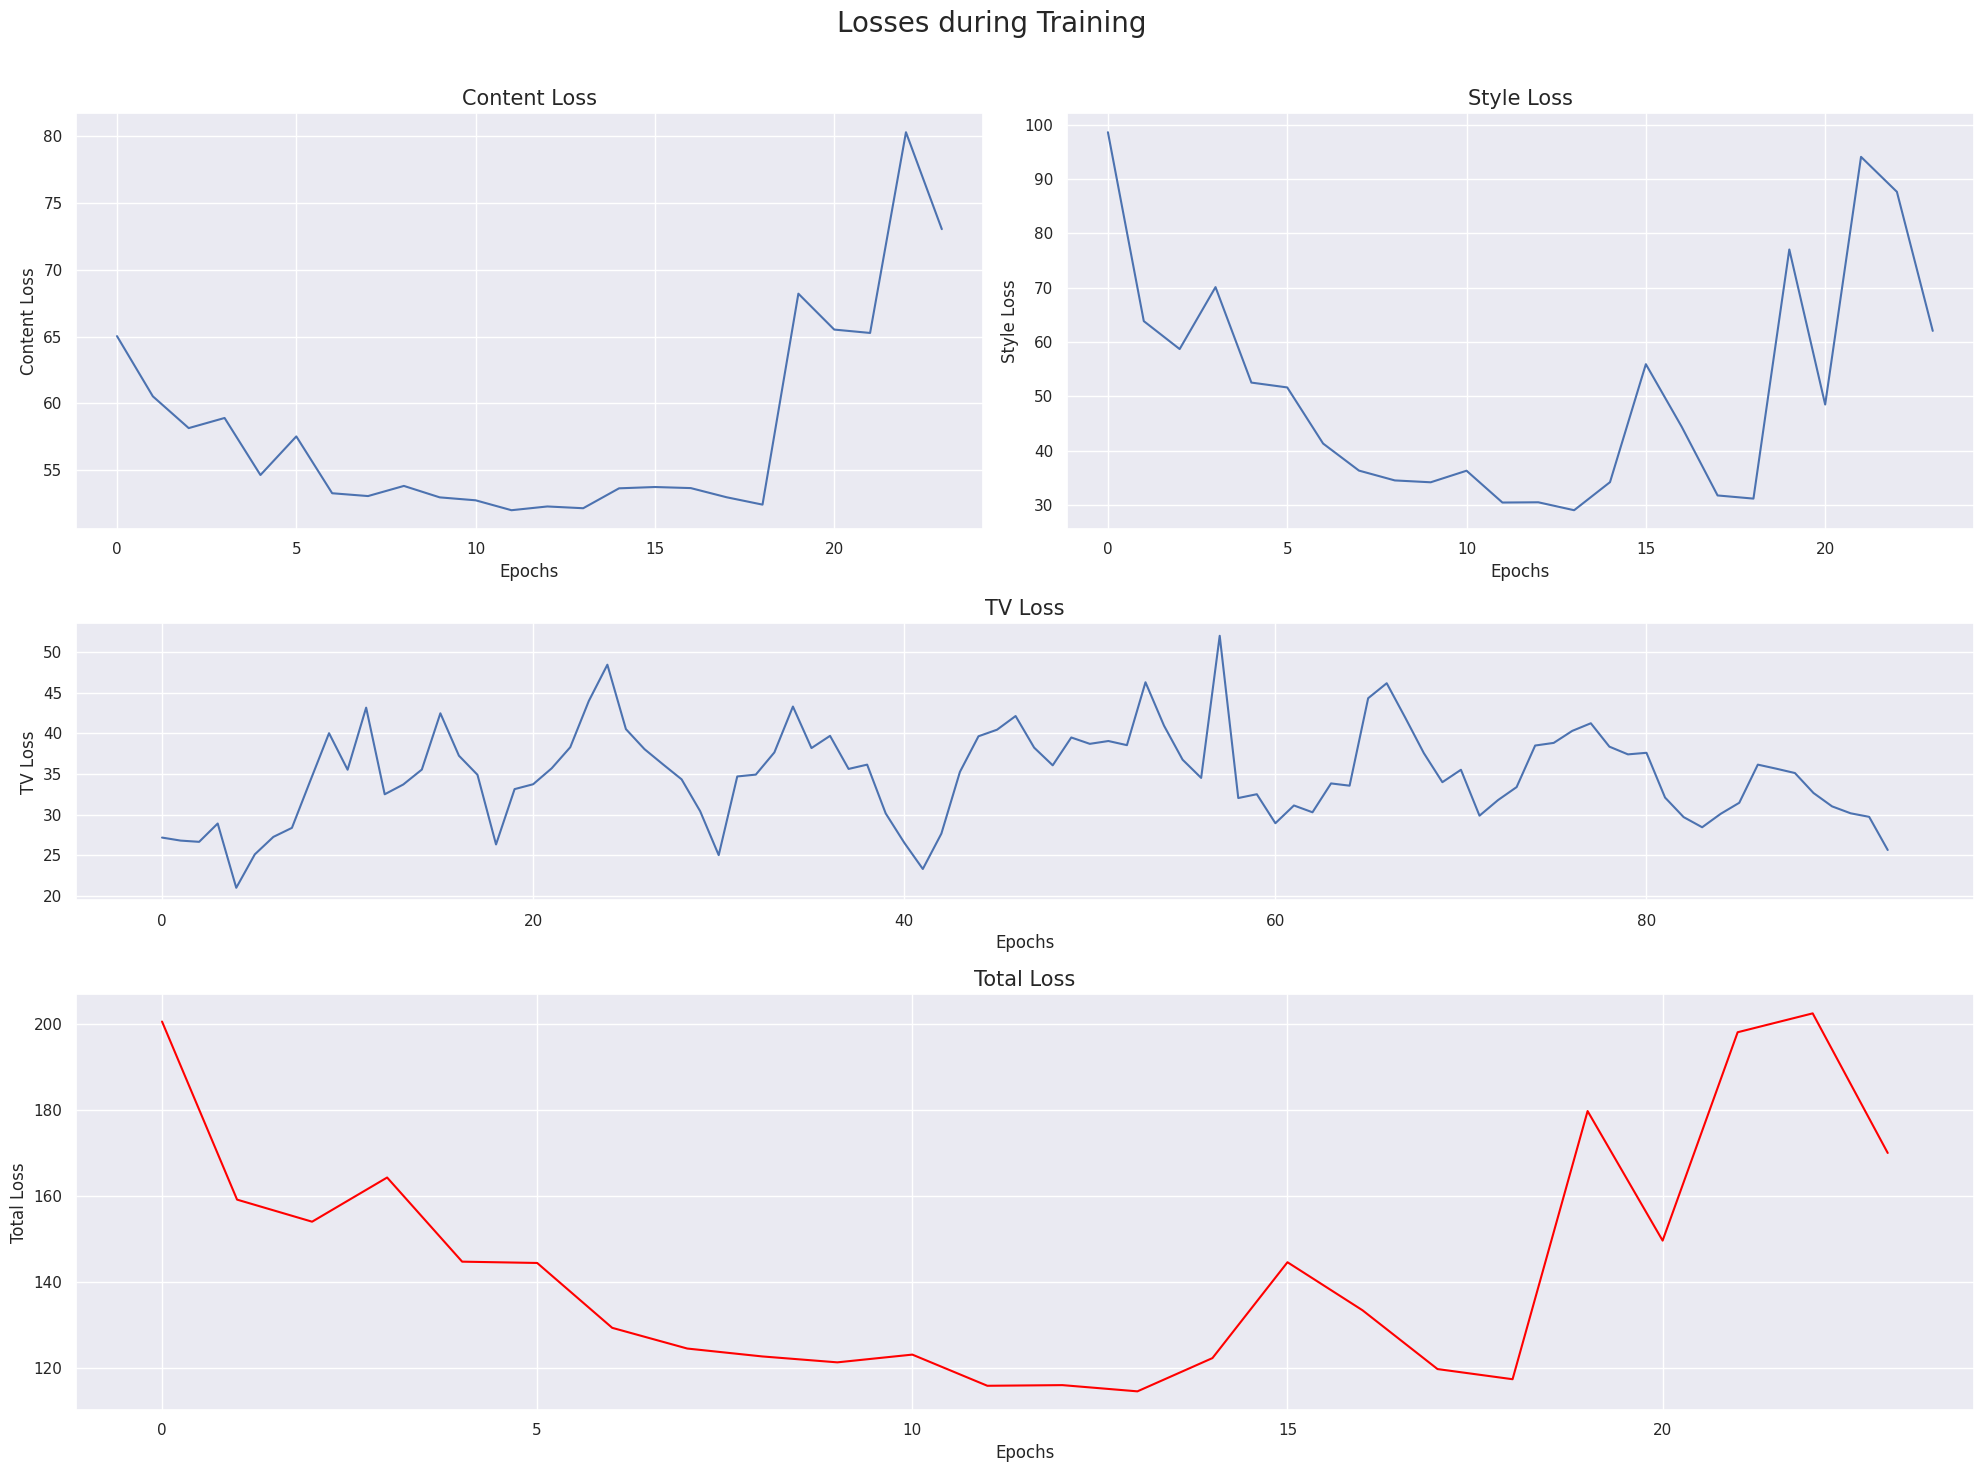

In [14]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

fig = plt.figure(figsize=(20, 15))
gs = gridspec.GridSpec(3, 2, height_ratios=[3, 2, 3])  # Adjusted ratio

# Upper left: Content Loss
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(content_losses, label='Content Loss')
ax1.set_title('Content Loss', fontsize=15)
ax1.set_xlabel('Epochs')
ax1.set_ylabel('Content Loss')

# Upper right: Style Loss
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(style_losses, label='Style Loss')
ax2.set_title('Style Loss', fontsize=15)
ax2.set_xlabel('Epochs')
ax2.set_ylabel('Style Loss')

# Middle row (spanning both columns): TV Loss
ax3 = fig.add_subplot(gs[1, :])  # spans all columns in row 1
ax3.plot(tv_loss, label='TV Loss')
ax3.set_title('TV Loss', fontsize=15)
ax3.set_xlabel('Epochs')
ax3.set_ylabel('TV Loss')

# Bottom row (spanning both columns): Total Loss
ax4 = fig.add_subplot(gs[2, :])  # spans all columns in row 2
ax4.plot(losses, label='Total Loss', color='red')
ax4.set_title('Total Loss', fontsize=15)
ax4.set_xlabel('Epochs')
ax4.set_ylabel('Total Loss')

# Add title to fig
fig.suptitle('Losses during Training', fontsize=20)
plt.tight_layout(rect=[0, 0, 1, 0.97])  # leave space for suptitle
plt.show()


In [ ]:
# After your training loop
# Save model components
import time
timestamp = time.strftime("%Y%m%d-%H%M%S")

torch.save(pipeline.state_dict(), f'/root/BiOSGen/checkpoints/main/pipeline_best_{num_epochs}_epoch_512_{timestamp}.pth')

# Save the entire model state including optimizer
checkpoint = {
    'epoch': epoch,
    'model_state_dict': pipeline.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'best_loss': best_loss,
    'losses': losses,
    'content_losses': content_losses,
    'style_losses': style_losses
}

torch.save(checkpoint, f'/root/BiOSGen/checkpoints/main/pipeline_full_{num_epochs}_epoch_512_{timestamp}.pth')

Text(0.5, 1.0, 'Generated Image')

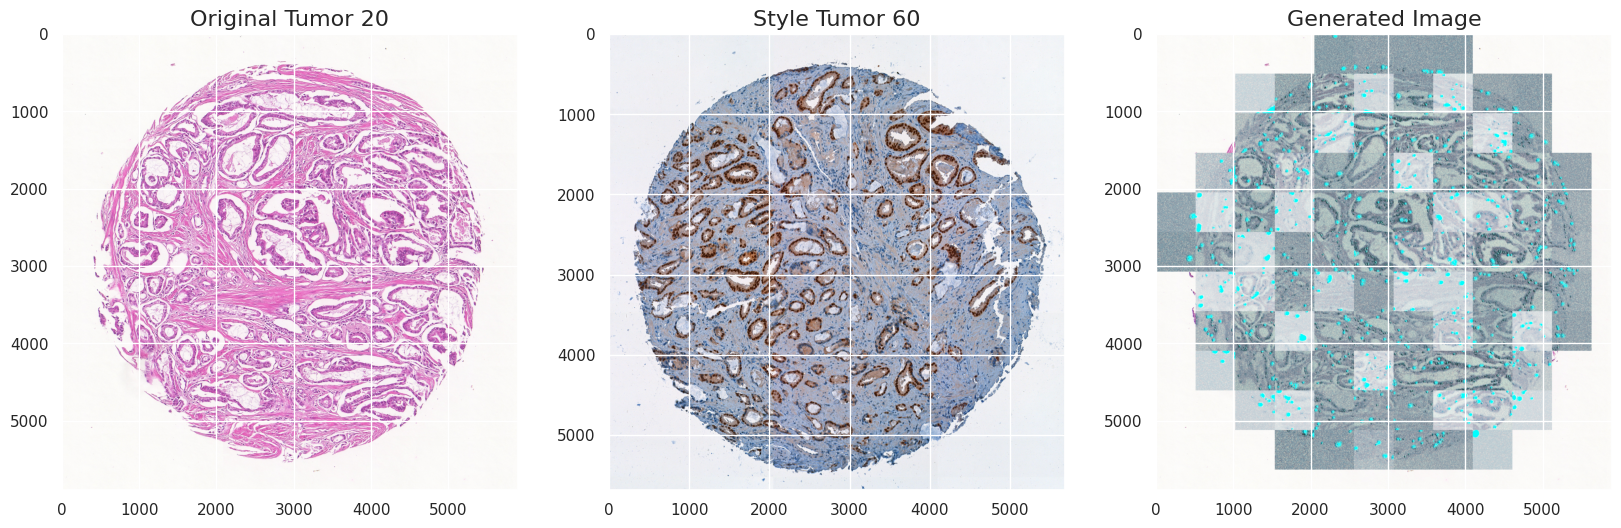

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 15))  # 1x5 grid

# Plot original source image
axes[0].imshow(np.array(Image.open(tree_src.antibodies[idx_src])), cmap='viridis')
axes[0].set_title(f'Original Tumor {idx_src}', fontsize=16)

# Plot original destination image
axes[1].imshow(np.array(Image.open(tree_dst.antibodies[idx_dst])), cmap='viridis')
axes[1].set_title(f'Style Tumor {idx_dst}', fontsize=16)

# Plot decoded image
gen = []
with torch.no_grad():
    for i in range(len(patches_src)):
        # Assign idx_src and idx_dst to the patches
        src = patches_src[i]
        dst = patches_dst[torch.randint(0, len(patches_dst), (1,)).item()]

        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src).to(device)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst).to(device)

        timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

        # forward pass
        out = pipeline(src_tensor, dst_tensor, timesteps)
        gen.append(out.to(torch.uint8)[0].permute(1,2,0).detach().cpu().numpy())

generated = PatchesUtilities.replace_patches_in_image(
    original_image=np.array(Image.open(tree_src.antibodies[idx_src])),
    tissue_mask=PatchesUtilities.get_tissue_mask(np.array(Image.open(tree_src.antibodies[idx_src]))),
    generated_patches=gen
)
axes[2].imshow(generated, cmap='viridis')
axes[2].set_title(f'Generated Image', fontsize=16)

In [ ]:
pipeline.train()
idx_src = 20 # torch.randint(0, len(tree_src.antibodies), (1,)).item()
patches_src = PatchesUtilities.get_image_patches_full(
    image = np.array(Image.open(tree_src.antibodies[idx_src])),
)

idx_dst = 60 # torch.randint(0, len(tree_dst.antibodies), (1,)).item()
patches_dst = PatchesUtilities.get_image_patches_full(
    image = np.array(Image.open(tree_dst.antibodies[idx_dst])),
)
print("idx_src: ", idx_src)
print("idx_dst: ", idx_dst)

fig, axes = plt.subplots(1, 3, figsize=(20, 15))  # 1x5 grid

# Plot original source image
axes[0].imshow(np.array(Image.open(tree_src.antibodies[idx_src])), cmap='viridis')
axes[0].set_title(f'Original Tumor {idx_src}', fontsize=16)

# Plot original destination image
axes[1].imshow(np.array(Image.open(tree_dst.antibodies[idx_dst])), cmap='viridis')
axes[1].set_title(f'Style Tumor {idx_dst}', fontsize=16)

# Plot decoded image
gen = []
with torch.no_grad():
    for i in range(len(patches_src)):
        # Assign idx_src and idx_dst to the patches
        src = patches_src[i]
        dst = patches_dst[torch.randint(0, len(patches_dst), (1,)).item()]

        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src).to(device)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst).to(device)

        timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

        # forward pass
        out = pipeline(src_tensor, dst_tensor, timesteps)
        gen.append(out.to(torch.uint8)[0].permute(1,2,0).detach().cpu().numpy())

generated = PatchesUtilities.replace_patches_in_image_full(
    original_image=np.array(Image.open(tree_src.antibodies[idx_src])),
    generated_patches=gen
)
axes[2].imshow(generated, cmap='viridis')
axes[2].set_title(f'Generated Image', fontsize=16)

idx_src:  20
idx_dst:  60


In [ ]:
pipeline.eval()
# for m in pipeline.modules():
#     if isinstance(m, nn.BatchNorm2d):
#         m.train()


OSGenPipeline(
  (encoder): VanillaEncoder(
    (encoder): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
      (1): Sequential(
        (0): Conv2d(64, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
        (2): LeakyReLU(negative_slope=0.01)
      )
    )
    (fc_mu): Linear(in_features=32, out_features=64, bias=True)
    (fc_var): Linear(in_features=32, out_features=64, bias=True)
    (noise_predictor): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (decoder_input): Linear(in_features=64, out_features=8192, bias=True)
    (decoder): Sequential(
      (0): Sequential(
        (0): ConvTranspose2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=

In [ ]:
idx_src = 20 # torch.randint(0, len(tree_src.antibodies), (1,)).item()
patches_src = PatchesUtilities.get_image_patches_full(
    image = np.array(Image.open(tree_src.antibodies[idx_src])),
)

idx_dst = 60 # torch.randint(0, len(tree_dst.antibodies), (1,)).item()
patches_dst = PatchesUtilities.get_image_patches_full(
    image = np.array(Image.open(tree_dst.antibodies[idx_dst])),
)
print("idx_src: ", idx_src)
print("idx_dst: ", idx_dst)

idx_src:  20
idx_dst:  60


Text(0.5, 1.0, 'Generated Image')

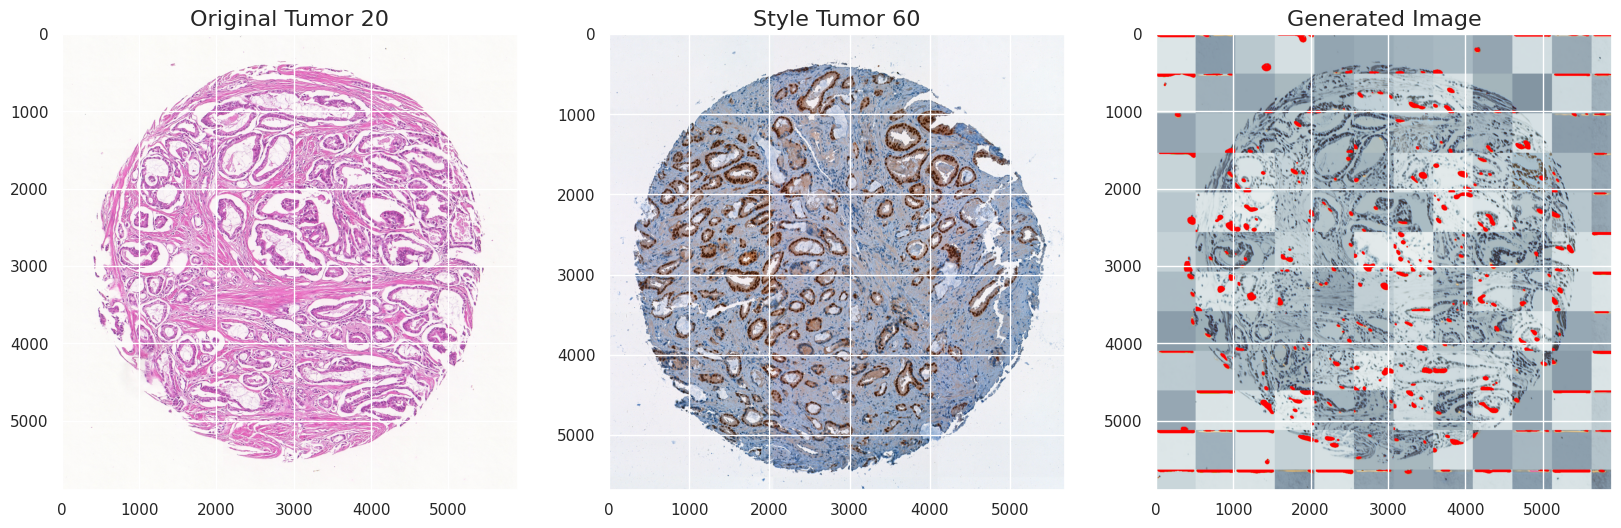

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(20, 15))  # 1x5 grid

# Plot original source image
axes[0].imshow(np.array(Image.open(tree_src.antibodies[idx_src])), cmap='viridis')
axes[0].set_title(f'Original Tumor {idx_src}', fontsize=16)

# Plot original destination image
axes[1].imshow(np.array(Image.open(tree_dst.antibodies[idx_dst])), cmap='viridis')
axes[1].set_title(f'Style Tumor {idx_dst}', fontsize=16)

# Plot decoded image
gen = []
with torch.no_grad():
    for i in range(len(patches_src)):
        # Assign idx_src and idx_dst to the patches
        src = patches_src[i]
        dst = patches_dst[torch.randint(0, len(patches_dst), (1,)).item()]

        # Convert to tensors
        src_tensor = Utilities.convert_numpy_to_tensor(src).to(device)
        dst_tensor = Utilities.convert_numpy_to_tensor(dst).to(device)

        timesteps = torch.randint(0, 1000, (batch_size,), device=device)  # Random timesteps

        # forward pass
        out = pipeline(src_tensor, dst_tensor, timesteps)
        gen.append(out.to(torch.uint8)[0].permute(1,2,0).detach().cpu().numpy())

generated = PatchesUtilities.replace_patches_in_image_full(
    original_image=np.array(Image.open(tree_src.antibodies[idx_src])),
    generated_patches=gen
)
axes[2].imshow(generated, cmap='viridis')
axes[2].set_title(f'Generated Image', fontsize=16)